# Currents in the Haldane model

In [68]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt

from lattice import OpenLattice
from hamiltonian import OpenHamiltonian
from currents import compute_currents
from plot_lattice import plot_voronoi

## Hamiltonian parameters

Hamiltonian:

$$ H = \sum_{ij} A_{ij}\ c^\dagger_i c_j = t_1 \sum_{\langle ij\rangle} c^\dagger_i c_j + t_2 \sum_{\langle\langle ij\rangle\rangle} e^{i\phi_{ij}} c^\dagger_i c_j $$

In [69]:
# Lattice sizes
Nx = Ny = 20
N = int(Nx*Ny*0.5)

# Haldane Hamiltonian's parameters
t1 = 1
t2 = 1
dphi = 0.5
lattice_imbalance = 0

# Harmonica trap strength
trap_potential = 1/50

# Temperature
T = 0

lattice = OpenLattice(Nx, Ny, N)
hopping_params = (t1, t2, dphi)
hoppings_type = 'haldane'
ham = OpenHamiltonian(lattice, hopping_params, hoppings_type,
                      trap_potential, lattice_imbalance)

print(f'Number of sites = {lattice.L}')
print(f'Number of particles = {lattice.Np}')

Number of sites = 800
Number of particles = 200


## Hamiltonian diagonalization

$$ H = \sum_{ij} c^\dagger_i A_{ij} c_j = \sum_{ij} c^\dagger_i V_{im} D_m V^*_{jm} c_j = \sum_m f^\dagger_m D_m f_m $$

Therefore the new basis is

$$f^\dagger_m = \sum_i V_{im} c^\dagger_i,\quad f_m = \sum_i V^*_{im} c_i $$

The occupation numbers of these new basis at a finite temperature $T$ are given by the Fermi-Dirac distribution

$$ \langle f^\dagger_m f_n \rangle = \delta_{mn}\frac{1}{1+e^{(E_m - \mu)/T}}$$

with $E_m$ the eigenenergy of $f^\dagger_m$ and $\mu$ the chemical potential, which we choose to be in the middle between the eigenenergy levels $N$ and $N+1$, with $N$ the particle number of the state.

The expected values of the two-body operators at finite temperature are

$$ \langle c^\dagger_i c_j\rangle = \sum_{mn} V^*_{im} V_{jn} \langle f^\dagger_m f_n\rangle = \sum_m V^*_{im} V_{jm} \frac{1}{1+e^{(E_m - \mu)/T}}$$

In [70]:
w, v = eigh(ham.A)

# Chemical potential
mu = (w[N-1] + w[N])/2

# Fermi-Dirac distribution
if np.isclose(T, 0):
    fd_dist = np.zeros(np.size(w))
    fd_dist[:N] = 1
else:
    fd_dist = 1/(1 + np.exp((w-mu)/T))

# Expected values
expected = np.einsum('im,jm,m->ij', np.conj(v), v, fd_dist)

## Occupation numbers


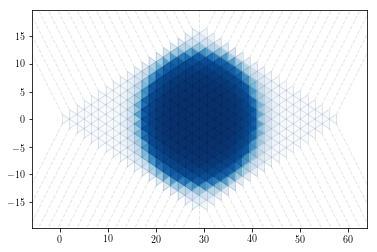

In [71]:
occupations = np.real(np.diag(expected))
plot_voronoi(lattice, occupations)

## Currents

The time variation of the occupation number is
$$ \langle\frac{d}{dt}n_i\rangle = -i\langle\left[n_i,\ H\right]\rangle = -i\left(\sum_j A_{ij}\ \langle c^\dagger_i c_j\rangle - A_{ji}\ \langle c^\dagger_j c_i\rangle\right) = 2\sum_j \textit{Im} \left[A_{ij}\ \langle c^\dagger_i c_j\rangle\right]$$

The current flowing from site $i$ to site $j$ can be defined as

$$ J_{ij} = 2\ \textit{Im}\left[ A_{ij}\ \langle c^\dagger_i c_j\rangle\right] $$

The current conservation law is thus conserved as

$$ \langle\frac{d}{dt}n_i\rangle = \sum_j J_{ij} $$

Max current: 0.1433993880672419
Min current: -0.1433993880672419
Max local derivative: 0.025337272346554064
Min local derivative: -0.02533727234655391


<Figure size 1296x1152 with 0 Axes>

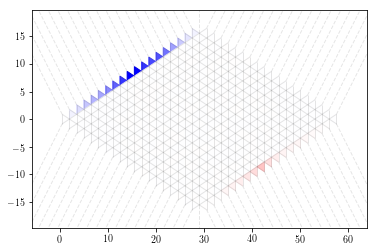

In [75]:
currents = 2*np.imag(ham.A*expected)
local_number_derivative = np.sum(currents, axis=1)
print(f'Max current: {np.max(currents)}')
print(f'Min current: {np.min(currents)}')
print(f'Max local derivative: {np.max(local_number_derivative)}')
print(f'Min local derivative: {np.min(local_number_derivative)}')

plot_voronoi(lattice, local_number_derivative, colormap='bwr')

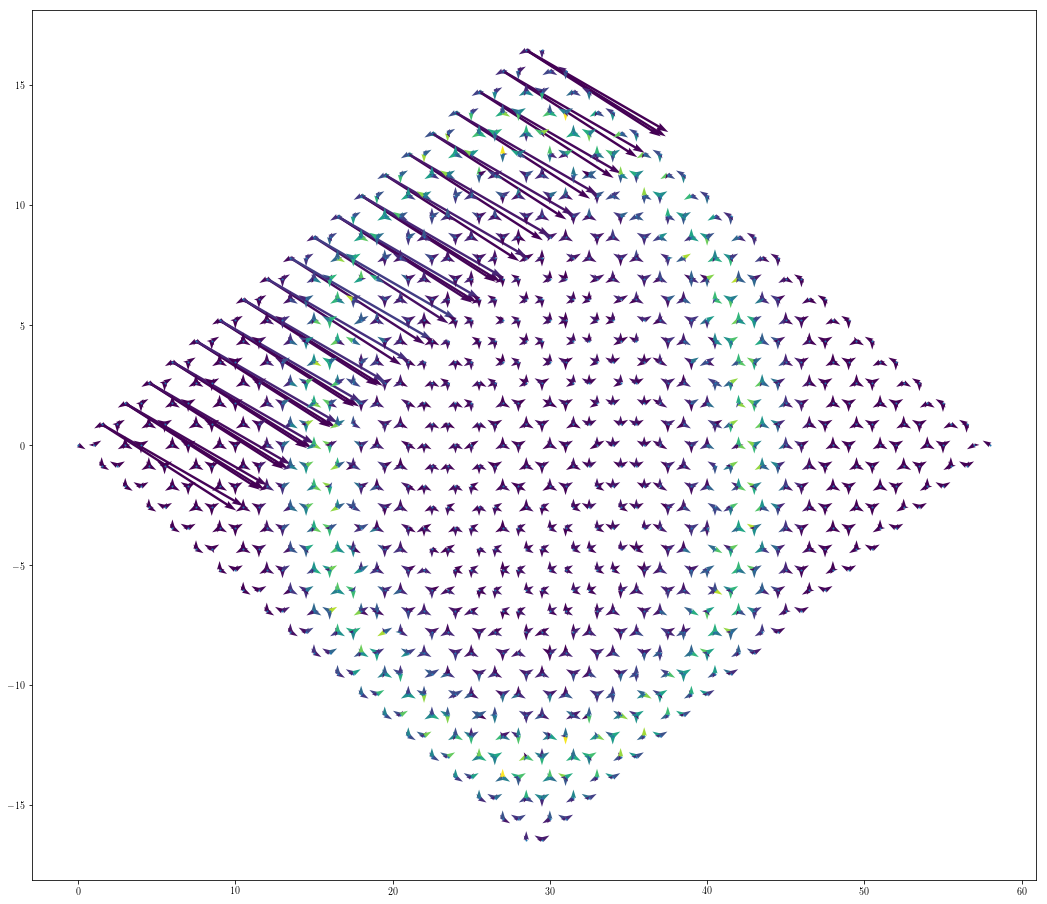

In [74]:
from numba import njit

@njit()
def compute_xyuvc(L, coords_pts, currents):

    x = []
    y = []
    u = []
    v = []
    c = []

    for i in range(L):
        for j in range(L):
            if (np.abs(currents[i, j]) > 0) and (currents[i, j] > 0):
                i_coords = coords_pts[i]
                j_coords = coords_pts[j]
                x.append(i_coords[0])
                y.append(i_coords[1])
                u.append(j_coords[0] - i_coords[0])
                v.append(j_coords[1] - i_coords[1])
                c.append(currents[i, j])
                
    return x, y, u, v, c

x, y, u, v, c = compute_xyuvc(lattice.L, lattice.coords_pts, currents)

fig = plt.figure(figsize=(18, 16))
plt.quiver(x, y, u, v, c)
plt.scatter(lattice.coords_pts[:, 0], lattice.coords_pts[:, 1], s=1)
plt.show()